<a href="https://colab.research.google.com/github/Nanase1994/BA810/blob/main/Lab8_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 8: Feature Selection

In this lab we select features from a high dimensional dataset. We do so by forward and backward sequential feature selection method.

We'll use the [`Hitters.csv` dataset](https://rdrr.io/cran/ISLR/man/Hitters.html). It contains data on baseball players from 1986-1987. You can get the data file from [`Slides/Data` folder](https://drive.google.com/drive/folders/1YBxtx7KILtcw6mFEkKmznaRASUHPLjI2?usp=sharing).


Our task is:

**Task**: *Predict the salary of a baseball player.*

The dataset has 19 predictors (and the Salary target):

1. `AtBat` Number of times at bat in 1986
1. `Hits` Number of hits in 1986
1. `HmRun` Number of home runs in 1986
1. `Runs` Number of runs in 1986
1. `RBI` Number of runs batted in in 1986
1. `Walks` Number of walks in 1986
1. `Years` Number of years in the major leagues
1. `CAtBat` Number of times at bat during his career
1. `CHits` Number of hits during his career
1. `CHmRun` Number of home runs during his career
1. `CRuns` Number of runs during his career
1. `CRBI` Number of runs batted in during his career
1. `CWalks` Number of walks during his career
1. `League` A factor with levels A and N indicating player's league at the end of 1986
1. `Division` A factor with levels E and W indicating player's division at the end of 1986
1. `PutOuts` Number of put outs in 1986
1. `Assists` Number of assists in 1986
1. `Errors` Number of errors in 1986
1. `NewLeague` A factor with levels A and N indicating layer's league at the beginning of 1987
1. `Salary` 1987 annual salary on opening day in thousands of dollars

Our suspicion is not all these are going to be helpful in predicting the salary of a player.

The outline of this lab is as follows:

1. Load, check, and split data
1. Construct a pipeline for preprocessing, append a feature selector, then a regression model
1. Grid search to select the maximum number of features to keep
1. Compare forward and backward search strategy for features selected and RMSE.

## Prepare data

The following two blocks assume that you have got the Hitters.csv datafile from the linked folder above and placed it in your `Colab Notebooks/BA810/Data` folder.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# drive_url = 'https://drive.google.com/open?id=143Mw3ZMAyrQuIvpgqsnSnE9_4KRJ32Yu&usp=drive_fs'
file_url = 'https://drive.google.com/uc?export=download&id=143Mw3ZMAyrQuIvpgqsnSnE9_4KRJ32Yu'

In [ ]:
rawdata = pd.read_csv(file_url, index_col=0)
rawdata.index.name = 'Player'  # The first column has player names, we'll use them as row index/labels
rawdata.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [ ]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, -Andy Allanson to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    obje

In [ ]:
rawdata.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,263.000000
mean,380.928571,101.024845,10.770186,50.909938,48.027950,38.742236,7.444099,2648.68323,717.571429,69.490683,358.795031,330.118012,260.239130,288.937888,106.913043,8.040373,535.925882
std,153.404981,46.454741,8.709037,26.024095,26.166895,21.639327,4.926087,2324.20587,654.472627,86.266061,334.105886,333.219617,267.058085,280.704614,136.854876,6.368359,451.118681
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.00000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000
25%,255.250000,64.000000,4.000000,30.250000,28.000000,22.000000,4.000000,816.75000,209.000000,14.000000,100.250000,88.750000,67.250000,109.250000,7.000000,3.000000,190.000000
50%,379.500000,96.000000,8.000000,48.000000,44.000000,35.000000,6.000000,1928.00000,508.000000,37.500000,247.000000,220.500000,170.500000,212.000000,39.500000,6.000000,425.000000
75%,512.000000,137.000000,16.000000,69.000000,64.750000,53.000000,11.000000,3924.25000,1059.250000,90.000000,526.250000,426.250000,339.250000,325.000000,166.000000,11.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.00000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000,2460.000000


From the column descriptions it seems that the numeric columns should actually be treated as numbers and the object columns are fine as object/category.

Note that the dataset has 322 records, but Salary (the target) has only 263 non-null values: there are some missing values in this column. Let's drop those records as we can't either train or test using these.

In [ ]:
data = rawdata.dropna() #drops all rows containing missing value in any column
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

There doesn't seem any other issues with the dataset. Let's split it into training/test.

In [ ]:
from sklearn.model_selection import train_test_split
X = data.drop('Salary', axis=1) # separate X ...
y = data['Salary'].copy()       # from y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0) #split all

## Prepare The Common Preprocessing Pipeline

As we have done before, we'll construct a pipeline for numeric and categorical columns. But, this time we'll append a feature selector to it before connecting to a regression model. Thus only the selected columns will be used by the final model.


Measure cross validation error on a grid that sets the number of features to select to different fractions.

Repeat for a classification exercise.

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn import set_config
set_config(display='diagram') # shows the pipeline graphically when printed

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_encoder', OneHotEncoder(drop='first'))
    ])

prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object))
])

prep_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x78df3ddcba10>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(drop='first'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x78df3ddca990>)])

Let's measure the cross validation error of a linear regression model, as a baseline.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(prep_pipeline, LinearRegression())
lin_cv_rmses = -cross_val_score(lin_reg, X_train, y_train,
                              scoring="neg_root_mean_squared_error", cv=5)
print('Cross validation error {:.0f}'.format(lin_cv_rmses.mean()))

Cross validation error 341


Rather high on average salary of 536 (thousand dollars).

## Implement Univariate Feature Selection with `SelectKBest`

Now, we'll experiment with various feature selection techniques, starting with univariate techniques.

We utilize `SelectKBest` from `scikit-learn` for this purpose, with `f_regression` as the test statistic. The F-score, used in `f_regression`, is particularly suited for regression tasks. It is calculated for each feature as:

$$
F = \frac{r^2}{(1 - r^2)} \times (n - 2)
$$

where $r$ is the correlation coefficient and $n$ is the number of samples. This F-score measures how significantly each feature contributes to the model's predictive power. Note, while the correlation, $r$, could be postive or negative, $F$ is always positive, as intended. Strong negative correlation is as helpful for prediction as strong positive correlation.

`k` is a hyper parameter for `SelectKBest`. It can't determine it on its own. So, we employ `GridSearchCV` to optimize the number of features (`k`).



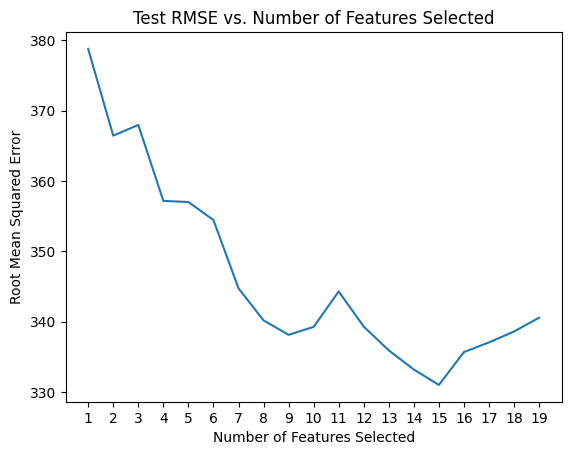

,param_select__k,mean_test_score
14,15,-331.016422
13,14,-333.203020
15,16,-335.687186
12,13,-335.924394
16,17,-337.064007



The selected features are ['num__AtBat' 'num__Hits' 'num__HmRun' 'num__Runs' 'num__RBI' 'num__Walks'
 'num__Years' 'num__CAtBat' 'num__CHits' 'num__CHmRun' 'num__CRuns'
 'num__CRBI' 'num__CWalks' 'num__PutOuts' 'cat__Division_W']


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

k_best_pipe = Pipeline([
    ('prep', prep_pipeline),
    ('select', SelectKBest(score_func=f_regression)), # need to tell how many to select, set later
    ('model', LinearRegression()) # Not necessary for feature selection, need to determine best k.
      # Of course, you can use any other regression model here.
])

param_grid = {
    'select__k': range(1, X_train.shape[1] + 1)
}

grid_search = GridSearchCV(k_best_pipe, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)


# Examine the results
cv_res = pd.DataFrame(grid_search.cv_results_)
plt.plot(cv_res["param_select__k"], -cv_res["mean_test_score"])
plt.xlabel("Number of Features Selected")
plt.ylabel("Root Mean Squared Error")
plt.title("Test RMSE vs. Number of Features Selected")
plt.xticks(np.arange(min(cv_res["param_select__k"]), max(cv_res["param_select__k"]) + 1, 1))
plt.show()

display(cv_res.sort_values(by="mean_test_score", ascending=False).filter(regex = '(^param_|mean_test_score)', axis=1).head())

best_model = grid_search.best_estimator_
print(f'\nThe selected features are {best_model["prep"].get_feature_names_out()[best_model["select"].get_support()]}')
# Not easy to extract selected feature names inside the pipeline. We get the columns produced by
# "prep" step before "select" and use the 0/1 indices of used columns from the "select" step to
# print them.

The strategy selects over 3/4th of the features. Since it only measures to what extent each feature is related to the outcome, in isolation, it may include redundant features (when other features are present).

## Selecting in features in the context of others using the `SelectFromModel`

We shift from `SelectKBest`, which considers each feature individually, to `SelectFromModel` which considers the importance of each feature in the context of other features. We use Lasso to select features that have coefficient maginitudes (considered importance in many such exercises) above a threshold (tunable). Lasso, can turn certain features to 0, effectively eliminating them.

By default the magnitude of feature coefficients on a linear model are used as their importance metric. The scale, and standard deviation, of a feature can have an impact on the coefficient.



To be able to compare across features we need to standardize the numeric features (which we are doing using `StandardScaler` in `prep_pipeline`). Let's attach the `SelectFromModel` to it for feature selection.


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import pandas as pd

# Create a pipeline
model_pipe = Pipeline([
    ('prep', prep_pipeline),
    ('select', SelectFromModel(Lasso())), # by default selects all the nonzero features from Lasso
    ('model', LinearRegression()) # Not needed for feature selection; building model with selected features.
])
model_pipe.fit(X_train, y_train)

# Extract and print the selected features
selected_features = model_pipe['prep'].get_feature_names_out()[model_pipe['select'].get_support()]
print(f'The number of selected features is {len(selected_features)}')
print(f'The selected features are {selected_features}')
print(f'The coefficients are {np.round(model_pipe["model"].coef_, 2)}')

The number of selected features is 17
The selected features are ['num__AtBat' 'num__Hits' 'num__HmRun' 'num__Runs' 'num__RBI' 'num__Walks'
 'num__CAtBat' 'num__CHits' 'num__CRuns' 'num__CRBI' 'num__CWalks'
 'num__PutOuts' 'num__Assists' 'num__Errors' 'cat__League_N'
 'cat__Division_W' 'cat__NewLeague_N']
The coefficients are [-278.43  314.16   84.77  -36.16  -59.95  150.93 -291.57  268.24  261.16
  133.42 -210.02   56.72   68.24  -40.02   32.56 -115.8     1.77]


Though the default with `Lasso` model is to select non-zero, we can ask the selection routine to keep all coefficients that are greater than the mean or median of all learnt coefficients. This indirectly controls how many we keep.

`SelectFromModel` can not determine the threshold to keep features. It needs to be told the threshold -- a hyperparameter. Therefore, as before, we use `GridSearchCV`, this time to search among combinations of Lasso's alpha parameter and feature selection thresholds. This jointly optimizes regularization strength and the number of features.


In [ ]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Define the parameter grid to vary the Lasso alpha (regularization strength)
# and the threshold for SelectFromModel
param_grid = {
    'select__estimator__alpha': [10, 100, 1000],
    'select__threshold': ['mean', 'median']  # Example thresholds
}

# Create and fit the GridSearchCV
grid_search = GridSearchCV(model_pipe, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Extract and print the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Display the cross-validation results
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
display(cv_res.filter(regex='(^param_|mean_test_score)', axis=1))

# Get the best model
best_model = grid_search.best_estimator_

# Print the selected features
# Assuming prep_pipeline transforms or selects features, adjust accordingly
selected_features = best_model['prep'].get_feature_names_out()[best_model['select'].get_support()]
print(f'The selected features are {selected_features}')


Best parameters: {'select__estimator__alpha': 100, 'select__threshold': 'mean'}


,param_select__estimator__alpha,param_select__threshold,mean_test_score
2,100,mean,-331.156653
0,10,mean,-333.585328
4,1000,mean,-340.572243
3,100,median,-340.572243
5,1000,median,-340.572243
1,10,median,-348.778716


The selected features are ['num__Hits' 'num__Walks' 'num__CRuns' 'num__CRBI']


Obtains about the same RMSE as select-k-best, but with fewer features. This model can be easier to train and interpret.

## Recursive Feature Elimination

After experimenting with `SelectKBest` and `SelectFromModel`, we advance to Recursive Feature Elimination with Cross-Validation (RFECV). Like `SelectFromModel`, it selects certain number of features from the full set. However, they differ in how they go about doing so.

`SelectFromModel` typically uses a fitted model (a `Lasso` in last example) and picks the top features by importance. While doing so, it doesn't refit the model after removing some. It could lead to suboptimal results because removing one could increase/change the importance of another. For example, when age and income are both present, they may have smaller effects than when either is present alone (if age and income are correlated).

Recursive Feature Elimination overcomes this problem by reestimating the model after removing the feature that has least negative effect on prediction performance. RFECV measures the performance through cross validation.

After fitting RFECV to the training data, we plot the negative RMSE against the number of features to identify the optimal feature count. The selected features and the RMSE at this optimal point provide insights into the model's predictive strength.

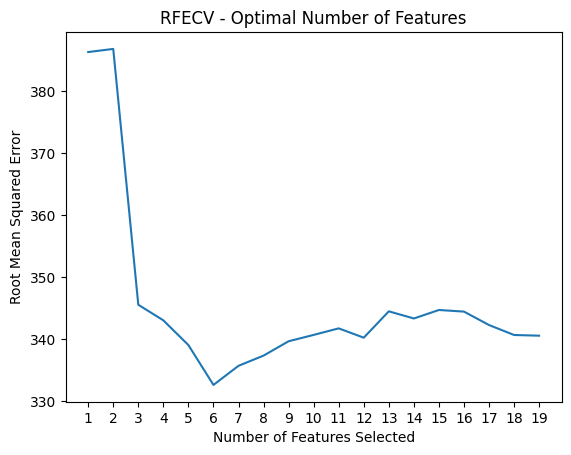

Optimal number of features: 6
Selected features: ['num__AtBat' 'num__Hits' 'num__Walks' 'num__CRuns' 'num__CRBI'
 'num__CWalks']
RMSE at optimal number of features: 332.64


In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

rfecv = RFECV(LinearRegression(), scoring='neg_root_mean_squared_error')
  # so we can access some results easily to examine

rfecv_pipe = Pipeline([
    ('prep', prep_pipeline),
    ('select', rfecv),
    # ('model', LinearRegression()) # uncomment/replace model to fit with the selected features
])

rfecv_pipe.fit(X_train, y_train)

plt.title("RFECV - Optimal Number of Features")
plt.xlabel("Number of Features Selected")
plt.ylabel("Root Mean Squared Error")
rmses = -rfecv.cv_results_['mean_test_score']
n_features = rfecv.cv_results_['n_features']
plt.plot(n_features, rmses)
plt.xticks(n_features)
plt.show()

optimal_num_features = rfecv.n_features_
optimal_rmse = -rfecv.cv_results_['mean_test_score'][optimal_num_features - 1]
print(f"Optimal number of features: {optimal_num_features}")
print(f"Selected features: {rfecv_pipe['prep'].get_feature_names_out()[rfecv.support_]}")
print(f"RMSE at optimal number of features: {optimal_rmse:.2f}")


## Sequential Feature Selection: Forward and Backward

Let's turn to Sequential Feature Selection (SFS) using MLxtend (which has a more versatile implementation). Recursive Feature Elimination eliminated the feature with least importance, as produced by a predictive model (for linear regression it is the magnitude of the coefficient). Importance need not correspond to the out-of-sample prediction performance. The best way to see what happens to out-of-sample prediction performance when we remove a feature, is to remove the feature and measure through CV. Thus, to decide which one to remove, we must remove each separately and measure CV error. This is better, but slower. You may not be able to do this quickly enough when you have more than 20 or so features.

SFS operates by either starting with no features and adding them one by one (forward selection) or starting with all features and removing them one at a time (backward elimination). This process is guided by the model's performance, allowing us to evaluate how each feature, in combination with others, contributes to the predictive power of the model.

In the following code, we implement both forward and backward sequential feature selection using `LinearRegression` as our estimator and `neg_root_mean_squared_error` for scoring. After fitting both forward and backward SFS, we'll compare their performance by examining the selected feature sets and corresponding RMSE scores. We'll also plot the performance metrics across different feature sets.

Additionally, we fit our `LinearRegression` model first with all features and then with the selected subset of features. This step will allow us to quantitatively assess the impact of feature selection by comparing the RMSE on test data for both models.

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(LinearRegression(), k_features="best", scoring='neg_root_mean_squared_error')

preprocess_pipeline = Pipeline([
    ('prep', prep_pipeline),
    ('select', sfs),
])

preprocess_pipeline


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x78df3ddcba10>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x78df3ddca990>)])),
                ('select',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           k_features='best',
                                           scoring='neg_root_mean_squared_error'))])

From the pipeline diagram, it is apparent that we first processing numeric and categorical separately as their initial steps are different. After them, we have only numbers in columns. We select features from the combined set of all preprocessed columns.

feature combination (0, 1, 2, 5, 8, 10, 12, 13, 17) gave best RMSE of 312.56.



,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(10,)","[-447.8973652712037, -334.83207046686437, -322...",-358.291544,"(10,)",69.671358,54.206684,27.103342
2,"(1, 10)","[-376.33352991679334, -296.50648258231485, -29...",-330.730622,"(1, 10)",75.686238,58.886464,29.443232
3,"(1, 10, 13)","[-369.57623130907797, -286.7434065222409, -284...",-325.452207,"(1, 10, 13)",77.778238,60.514111,30.257056
4,"(0, 1, 10, 13)","[-362.0919194239005, -290.30530495249826, -284...",-322.743985,"(0, 1, 10, 13)",73.166748,56.926216,28.463108
5,"(0, 1, 5, 10, 13)","[-349.67405036176615, -295.3769946114562, -279...",-320.146944,"(0, 1, 5, 10, 13)",73.109427,56.881618,28.440809
6,"(0, 1, 5, 10, 12, 13)","[-350.1170835207212, -282.5107688546792, -266....",-315.262033,"(0, 1, 5, 10, 12, 13)",72.227711,56.195613,28.097807
7,"(0, 1, 2, 5, 10, 12, 13)","[-347.37984696744354, -284.8063689881369, -266...",-313.734697,"(0, 1, 2, 5, 10, 12, 13)",71.364028,55.523638,27.761819
8,"(0, 1, 2, 5, 10, 12, 13, 17)","[-336.28303053839323, -293.2869634667752, -263...",-313.078343,"(0, 1, 2, 5, 10, 12, 13, 17)",65.721457,51.133526,25.566763
9,"(0, 1, 2, 5, 8, 10, 12, 13, 17)","[-335.7757451813363, -291.2746895606692, -262....",-312.560266,"(0, 1, 2, 5, 8, 10, 12, 13, 17)",64.458763,50.151107,25.075554
10,"(0, 1, 2, 4, 5, 8, 10, 12, 13, 17)","[-335.9321295726803, -290.80571145729436, -264...",-312.790908,"(0, 1, 2, 4, 5, 8, 10, 12, 13, 17)",64.189918,49.941937,24.970968


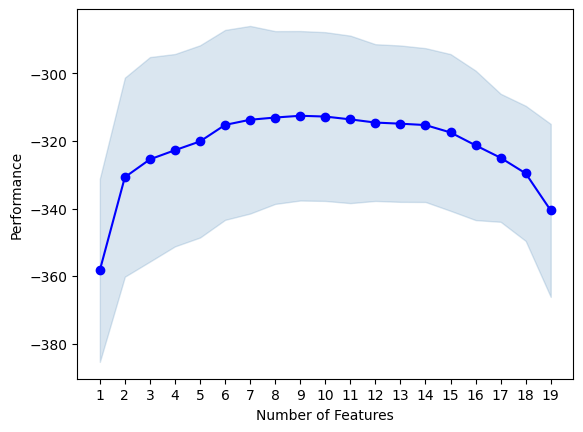

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import pandas as pd

processed_X = preprocess_pipeline.fit_transform(X_train, y_train)

print(f'feature combination {sfs.k_feature_idx_} gave best RMSE of {-sfs.k_score_:.2f}.\n')
display(pd.DataFrame.from_dict(sfs.get_metric_dict()).T)
plot_sfs(sfs.get_metric_dict(), kind='std_err');


feature combination (0, 1, 5, 10, 11, 12, 13, 17) gave best RMSE of 312.



,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
19,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-407.4192721497779, -313.096037439324, -285.6...",-340.572243,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",65.786362,51.184025,25.592012
18,"(0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14...","[-345.93257744635497, -314.2843774113651, -288...",-329.600494,"(0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14...",51.399878,39.990851,19.995426
17,"(0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 1...","[-333.76611547432395, -309.9798671915842, -287...",-324.994964,"(0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 1...",48.685887,37.879274,18.939637
16,"(0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 1...","[-338.04956012429346, -287.82992905300824, -27...",-321.309378,"(0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 1...",56.857712,44.237232,22.118616
15,"(0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 1...","[-337.4997945062092, -287.7361003040248, -278....",-317.498056,"(0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 1...",59.614679,46.382246,23.191123
14,"(0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 17, 18)","[-336.9065357937648, -287.29621037155755, -275...",-315.309282,"(0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 17, 18)",58.506669,45.520177,22.760088
13,"(0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 17)","[-335.20908210442946, -287.866973191288, -276....",-314.658375,"(0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 17)",58.81668,45.761375,22.880688
12,"(0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 17)","[-334.3205968888155, -289.9028546372527, -277....",-314.061383,"(0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 17)",60.074028,46.739634,23.369817
11,"(0, 1, 2, 4, 5, 9, 10, 11, 12, 13, 17)","[-332.3211087242776, -289.69267953057795, -276...",-313.355483,"(0, 1, 2, 4, 5, 9, 10, 11, 12, 13, 17)",60.078038,46.742755,23.371377
10,"(0, 1, 2, 4, 5, 10, 11, 12, 13, 17)","[-328.6252977176327, -289.9914807704111, -275....",-312.416016,"(0, 1, 2, 4, 5, 10, 11, 12, 13, 17)",59.474145,46.272906,23.136453


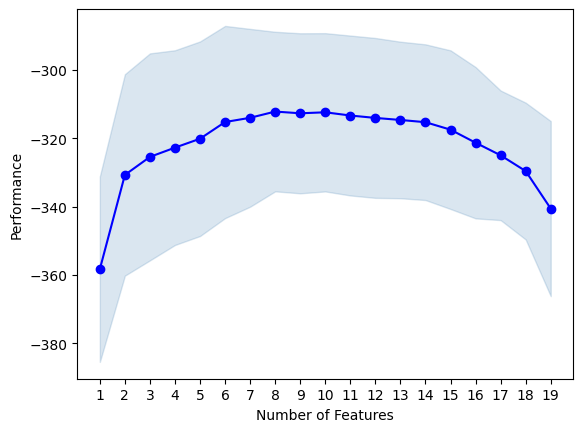

In [ ]:
sbs = SequentialFeatureSelector(
        LinearRegression(),
        forward=False,
        k_features="best",  # try "parsimonious": smallest no worse than 1 standard-errror of cv measures
        floating=False,     # try True: after each removal, consider if adding any would improve
        scoring='neg_root_mean_squared_error')

backward_preprocess_pipeline = Pipeline([
    ('prep', prep_pipeline),
    ('select', sbs),
])

backward_preprocess_pipeline.fit(X_train, y_train)

print(f'feature combination {sbs.k_feature_idx_} gave best RMSE of {-sbs.k_score_:.0f}.\n')
display(pd.DataFrame.from_dict(sbs.get_metric_dict()).T)
plot_sfs(sbs.get_metric_dict(), kind='std_err');


Based on these you'd probably use backward search, though, one should be skeptical of any difference. Part of the reason we are not seeing statistically significant difference is because of the small dataset (only 210 records).

On the other hand, the risk of overfitting is larger with small datasets, thus, feature selection becomes more important. This is part of the reason why feature selection methods are selecting a small subset (8) of all available (22) features. If the dataset was orders of magnitude larger, they may have selected more features.


Now, let's attach the preprocessor to a linear regression model and check the evaluation on test data.

In [ ]:
from sklearn.pipeline import make_pipeline

lin_reg.fit(X_train, y_train)

lin_reg_select = make_pipeline(backward_preprocess_pipeline, LinearRegression())
lin_reg_select.fit(X_train, y_train) # repeats the feature selection

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('prep',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x78df45884440>),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('cat_encoder',
                                                                                    OneHotEncoder(drop='first'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x78df457e8bf0>)])),
                                 ('select',
                                  SequentialFeatureSelector(estimator=LinearRegression(),
                                                            forward=False,
                                                            k_features=(1, 19),
                                                            scoring='neg_root_mean_squared_error'))])),
                ('linearregression', LinearRegression())])

In [ ]:
from sklearn.metrics import root_mean_squared_error

print(f'Test data RMSE with all features is: {root_mean_squared_error(y_test, lin_reg.predict(X_test)):.0f}')
print(f'Test data RMSE with best features is: {root_mean_squared_error(y_test, lin_reg_select.predict(X_test)):.0f}')

Test data RMSE with all features is: 359
Test data RMSE with best features is: 351


Using a subset seems to lead to slightly lower error, but these are based on only 53 test records -- the difference is unlikely to be statistically significant.

When the final model has hyperparameters, it is recommended that it be tuned with feature selection. The best features could vary depending on the value of the hyperparameters of the final model.

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector
from scipy.stats import loguniform
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from joblib import Memory
from tempfile import mkdtemp

sbs = SequentialFeatureSelector(LinearRegression(), forward=False, k_features="best",
        floating=False, scoring='neg_root_mean_squared_error')

full_backward_preprocess_pipeline = Pipeline([
    ('prep', prep_pipeline),
    ('select', sbs),
    ('model', Ridge())
  ],
  memory=Memory(location=mkdtemp(), verbose=0) # cache upstream results in pipeline to speedup
)

param_distributions = [{
    "model__alpha": loguniform(1e-3, 1e3)
}]

rnd_search = RandomizedSearchCV(full_backward_preprocess_pipeline, param_distributions, random_state = 42,
                                n_iter = 100, cv=5, scoring='neg_root_mean_squared_error')
rnd_search.fit(X_train, y_train)

print(f"Best hyperparameters: {rnd_search.best_params_}")
print(f"Best CV RMSE: {-rnd_search.best_score_:.2f}")
best_model_from_random_search = rnd_search.best_estimator_

print(f'Selected feature combination (Indices) {best_model_from_random_search['select'].k_feature_idx_}\n')
selected_features_from_rs = best_model_from_random_search['prep'].get_feature_names_out()[list(best_model_from_random_search['select'].k_feature_idx_)]
print(f"Selected feature names after Randomized Search: {selected_features_from_rs}")

Best hyperparameters: {'model__alpha': np.float64(6.688747907702058)}
Best CV RMSE: 329.02
Selected feature combination (Indices) (0, 1, 5, 10, 11, 12, 13, 17)

Selected feature names after Randomized Search: ['num__AtBat' 'num__Hits' 'num__Walks' 'num__CRuns' 'num__CRBI'
 'num__CWalks' 'num__PutOuts' 'cat__Division_W']


Scikit learn offers [several variants of these feature selection techniques](https://scikit-learn.org/stable/modules/feature_selection.html#).
MLXtend has strong [implementations too](https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/).

Do explore them.



**Exercises**:

1. Employ the two feature selection approaches (forward and backward sequential search) on `College.csv` file found in the folder linked at the top of this file. The goal is to predict the number of applications a college would receive.
    1. What features do you end up using and which strategy did you use to arrive there?
    1. Did you run into any computational issues while experimenting with the search strategies?
1. All these methods can be applied to classification problems too. Try applying these to predict Purchase (of insurance) in `Caravan.csv` dataset. You can learn more about this data at https://liacs.leidenuniv.nl/~puttenpwhvander/library/cc2000/data.html
    1. What are some computational challenges that you encountered?
    1. This dataset has many more columns. Which feature search strategies did you put together to identify an informative subset of columns?
    1. What columns did you use and what was the improvement over not using any feature selection (or selecting them based on univariate search strategy)?

    The details will have to be adapted while going from regression to classification. Switch to classification models (like `LogisticRegression` or `RandomForestClassifier`) and update scoring metrics to those suitable for classification (e.g., `accuracy`, `roc_auc`). Adapt feature selection methods to classification-specific ones (e.g., using `chi2` in `SelectKBest`), and employ stratified cross-validation for balanced class representation. Adjust preprocessing steps for categorical data and consider feature scaling based on model choice. Shift post-modeling analysis to confusion matrices and ROC curves, and interpret results in terms of class probabilities or labels instead of continuous values.


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector

file_url = 'https://drive.google.com/uc?export=download&id=14DFjVXH-8ifih63CMFNJKbX1aAxFhNeT'


df = pd.read_csv(file_url, index_col=0)
df.head()

target = "Apps"
y = df[target].values

# # 简单区分数值/类别列
cat_cols = [c for c in df.columns if df[c].dtype == "object" and c != target]
num_cols = [c for c in df.columns if c not in cat_cols + [target]]

# # 2) 预处理与模型
numeric_tf = Pipeline(steps=[("scaler", StandardScaler())])
categorical_tf = Pipeline(steps=[("ohe", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols)
    ]
)

base_est = Ridge(alpha=5.0, random_state=42)

# # 3) 通过 SFS 选择特征（前向/后向各跑一次）
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = "neg_mean_absolute_error"  # 或 "r2"

def run_sfs(direction, k_select):
    pipe = Pipeline(steps=[("prep", preprocess),
                          ("model", base_est)])
    sfs = SequentialFeatureSelector(
        estimator=base_est,
        n_features_to_select=k_select,
        direction=direction,
        scoring=scoring,
        cv=cv,
    )
#     # 注意：SFS 作用在“预处理后”的特征空间；为了获得“原始列名 + OHE 展开名”，需拟合后取 get_feature_names_out
#     # 我们先拟合预处理器拿到展开后的列名
    preprocess.fit(df[num_cols + cat_cols])
    feat_names = preprocess.get_feature_names_out()
    sfs.set_output(transform="pandas")
    sfs.fit(preprocess.transform(df[num_cols + cat_cols]), y)

#     # 被选中的掩码
    support = sfs.get_support()
    selected = feat_names[support]

#     # 训练一个最终模型并交叉验证
    final_pipe = Pipeline([("prep", preprocess), ("model", base_est)])
    scores = cross_val_score(final_pipe, df[num_cols + cat_cols], y, cv=cv, scoring=scoring, n_jobs=-1)
    return selected, scores.mean(), scores.std()

# # 试几种 k（例如 8 与 10）
for direction in ["forward", "backward"]:
    for k in [8, 10, 12]:
        selected, mean_score, std_score = run_sfs(direction, k)
        print(f"[College][{direction}][k={k}] {scoring} = {mean_score:.4f} ± {std_score:.4f}")
        print("Selected features (post-transform):", list(selected)[:20], " ...")


[College][forward][k=8] neg_mean_absolute_error = -634.4056 ± 73.5832
Selected features (post-transform): ['num__Accept', 'num__Outstate', 'num__Books', 'num__Personal', 'num__Terminal', 'num__S.F.Ratio', 'num__perc.alumni', 'num__Expend']  ...
[College][forward][k=10] neg_mean_absolute_error = -634.4056 ± 73.5832
Selected features (post-transform): ['num__Accept', 'num__Outstate', 'num__Room.Board', 'num__Books', 'num__Personal', 'num__PhD', 'num__Terminal', 'num__S.F.Ratio', 'num__perc.alumni', 'num__Expend']  ...
[College][forward][k=12] neg_mean_absolute_error = -634.4056 ± 73.5832
Selected features (post-transform): ['num__Accept', 'num__Enroll', 'num__P.Undergrad', 'num__Outstate', 'num__Room.Board', 'num__Books', 'num__Personal', 'num__PhD', 'num__Terminal', 'num__S.F.Ratio', 'num__perc.alumni', 'num__Expend']  ...
[College][backward][k=8] neg_mean_absolute_error = -634.4056 ± 73.5832
Selected features (post-transform): ['num__Accept', 'num__Enroll', 'num__F.Undergrad', 'num__Ou

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, chi2, RFECV

# 1) 读取数据

file_url = 'https://drive.google.com/uc?export=download&id=145V9G8UgkxQVYCdm6y4zy3QxsOQ85sMX'


df = pd.read_csv(file_url, index_col=0)

y = (df["Purchase"].astype(str).str.upper() == "YES").astype(int).values
X = df.drop(columns=["Purchase"])

num_cols = X.columns.tolist()  # Caravan 基本都是数值
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2) 基线：标准化 + 逻辑回归（无特征选择）
logit = LogisticRegression(max_iter=2000, solver="liblinear", class_weight=None)

base_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", logit)
])

roc = cross_val_score(base_pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"[Caravan][No FS] ROC-AUC = {roc.mean():.4f} ± {roc.std():.4f}")

# 3) 方案A：SFS（前向/后向）
def sfs_run(direction, k_select):
    sfs_clf = LogisticRegression(max_iter=2000, solver="liblinear")
    sfs = SequentialFeatureSelector(
        estimator=sfs_clf,
        n_features_to_select=k_select,
        direction=direction,
        scoring="roc_auc",
        cv=cv,
    )
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("sfs", sfs),
        ("clf", sfs_clf)
    ])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    return scores

for direction in ["forward", "backward"]:
    for k in [12, 16, 20]:
        scores = sfs_run(direction, k)
        print(f"[Caravan][SFS-{direction}][k={k}] ROC-AUC = {scores.mean():.4f} ± {scores.std():.4f}")

# 4) 方案B：chi2 粗筛 + SFS 精筛
# chi2 需要非负 → 用 MinMaxScaler 到 [0,1]
chi2_k = 40
k_final = 16

chi2_pipe = Pipeline([
    ("mm", MinMaxScaler()),
    ("chi2", SelectKBest(score_func=chi2, k=chi2_k)),
])

X_chi2 = chi2_pipe.fit_transform(X, y)
sel_mask = chi2_pipe.named_steps["chi2"].get_support()
sel_names = np.array(num_cols)[sel_mask]
print(f"[Caravan][chi2@{chi2_k}] first-stage selected:", list(sel_names)[:10], "...")

# 在粗筛后的子空间上再做 SFS
sfs_clf2 = LogisticRegression(max_iter=2000, solver="liblinear")
sfs2 = SequentialFeatureSelector(
    estimator=sfs_clf2,
    n_features_to_select=k_final,
    direction="forward",
    scoring="roc_auc",
    cv=cv,
)

pipe_stage2 = Pipeline([
    ("scale", StandardScaler()),
    ("sfs", sfs2),
    ("clf", sfs_clf2)
])

scores_stage2 = cross_val_score(pipe_stage2, X.loc[:, sel_names], y, cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"[Caravan][chi2->{k_final} via SFS] ROC-AUC = {scores_stage2.mean():.4f} ± {scores_stage2.std():.4f}")

# 5) 方案C：RFECV（可作为稳健基线）
rfecv = RFECV(
    estimator=LogisticRegression(max_iter=2000, solver="liblinear"),
    step=1,
    cv=cv,
    scoring="roc_auc",
    min_features_to_select=10
)
pipe_rfecv = Pipeline([
    ("scale", StandardScaler()),
    ("rfecv", rfecv)
])
scores_rfecv = cross_val_score(pipe_rfecv, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"[Caravan][RFECV] ROC-AUC = {scores_rfecv.mean():.4f} ± {scores_rfecv.std():.4f}")


[Caravan][No FS] ROC-AUC = 0.7414 ± 0.0256
[Caravan][SFS-forward][k=12] ROC-AUC = 0.7414 ± 0.0270
[Caravan][SFS-forward][k=16] ROC-AUC = 0.7470 ± 0.0255
[Caravan][SFS-forward][k=20] ROC-AUC = 0.7457 ± 0.0273
